In [26]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import datetime

# ------------------------------
# 1. Load Data
# ------------------------------
# Update these paths as needed:
hr_path = "/kaggle/input/fitbit/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv"
calories_path = "/kaggle/input/fitbit/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlyCalories_merged.csv"
weight_path = "/kaggle/input/fitbit/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/weightLogInfo_merged.csv"

# Read the CSV files
df_hr = pd.read_csv(hr_path)
df_cal = pd.read_csv(calories_path)
df_weight = pd.read_csv(weight_path)

# ------------------------------
# 2. Convert Date/Time Columns
# ------------------------------
df_hr['Time'] = pd.to_datetime(df_hr['Time'], errors='coerce')
df_cal['ActivityHour'] = pd.to_datetime(df_cal['ActivityHour'], errors='coerce')
df_weight['Date'] = pd.to_datetime(df_weight['Date'], errors='coerce')

# ------------------------------
# 3. Aggregate Heart Rate Data (Hourly)
# ------------------------------
df_hr_hourly = df_hr.groupby(
    ['Id', df_hr['Time'].dt.floor('h')]
).agg({'Value': ['mean', 'min', 'max', 'std']}).reset_index()

# Flatten column names
df_hr_hourly.columns = ['Id', 'Hour', 'HR_Mean', 'HR_Min', 'HR_Max', 'HR_Std']

# ------------------------------
# 4. Calculate Daily Resting Heart Rate
# ------------------------------
df_hr['Date'] = df_hr['Time'].dt.date
# Get resting heart rate (RHR) as the 5th percentile of heart rate values for each day
df_resting = df_hr.groupby(['Id', 'Date'])['Value'].agg(
    lambda x: np.percentile(x, 5) if len(x) > 0 else np.nan
).reset_index()
df_resting.columns = ['Id', 'Date', 'RestingHR']
df_resting['Date'] = pd.to_datetime(df_resting['Date'])

# Calculate 7-day moving average for smoother trend analysis
df_resting = df_resting.sort_values(['Id', 'Date'])
df_resting['RHR_7day_MA'] = df_resting.groupby('Id')['RestingHR'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# ------------------------------
# 5. Analyze RHR Trends
# ------------------------------
# Function to analyze trend over the last n days
def analyze_trend(rhr_series, days=7):
    if len(rhr_series) < days:
        return "Insufficient data"
    
    recent_data = rhr_series.iloc[-days:]
    
    # Simple linear regression to get slope
    x = np.arange(len(recent_data))
    y = recent_data.values
    slope, _ = np.polyfit(x, y, 1)
    
    # Calculate percent change
    first_val = recent_data.iloc[0]
    last_val = recent_data.iloc[-1]
    percent_change = ((last_val - first_val) / first_val) * 100 if first_val > 0 else 0
    
    # Variability (standard deviation)
    variability = recent_data.std()
    
    # Determine trend direction and magnitude
    if abs(percent_change) < 3:
        direction = "consistent"
        magnitude = "stable"
    else:
        direction = "upward" if slope > 0 else "downward"
        if abs(percent_change) < 5:
            magnitude = "slight"
        elif abs(percent_change) < 10:
            magnitude = "moderate"
        else:
            magnitude = "significant"
    
    return {
        "direction": direction,
        "magnitude": magnitude,
        "percent_change": percent_change,
        "variability": variability,
        "slope": slope
    }

# ------------------------------
# 6. Smart Mirror Health Insights
# ------------------------------
def get_smart_mirror_insights(trend_data, last_rhr, bmi=None, hr_recovery=None, activity_level=None):
    direction = trend_data["direction"]
    magnitude = trend_data["magnitude"]
    variability = trend_data["variability"]
    
    # Base state assessment from RHR - Using simple, clear language
    if direction == "consistent":
        if last_rhr < 60:
            base_state = "Your heart is working efficiently even at rest - a sign of good fitness"
        elif last_rhr < 70:
            base_state = "Your resting heart rate is in a healthy range"
        elif last_rhr < 80:
            base_state = "Your heart rate is in a normal range, but there's room for improvement"
        else:
            base_state = "Your heart is working harder than ideal at rest"
    
    elif direction == "upward":
        if magnitude == "slight":
            base_state = "Your heart has been working a bit harder lately - this might indicate some fatigue"
        elif magnitude == "moderate":
            base_state = "Your heart rate has been increasing - this could be due to stress or the beginning of an illness"
        else:
            base_state = "Your heart rate has increased significantly - this could indicate stress, illness, or overtraining"
    
    elif direction == "downward":
        if magnitude == "slight":
            base_state = "Your heart has been working a bit less hard lately - a good sign of recovery"
        elif magnitude == "moderate":
            base_state = "Your heart rate has been decreasing - this shows your fitness is improving"
        else:
            base_state = "Your heart rate has decreased significantly - your fitness appears to be improving well"
    
    else:
        base_state = "It's hard to determine a clear pattern in your heart rate"
    
    # Daily consistency insights in simple terms
    if variability > 5:
        additional_insight = "Your daily heart rate varies quite a bit day to day"
    elif variability > 3:
        additional_insight = "Your heart rate shows some variation from day to day"
    else:
        additional_insight = "Your heart rate is very consistent day to day"
    
    
    # Heart rate recovery insights
    recovery_insight = ""
    if hr_recovery is not None:
        if hr_recovery < 15:
            recovery_insight = "Your heart doesn't slow down as quickly as it could after exertion."
        elif hr_recovery < 25:
            recovery_insight = "Your heart recovers at a normal rate after activity."
        else:
            recovery_insight = "Your heart recovers very quickly after activity - a sign of good fitness."
    
    # Activity level insights
    activity_insight = ""
    if activity_level is not None:
        if activity_level == "sedentary":
            activity_insight = "You could benefit from being more active throughout the day."
        elif activity_level == "moderate":
            activity_insight = "You have a good amount of activity in your day."
        else:  # active
            activity_insight = "You're maintaining an active lifestyle, which is great for your heart."
    
    # Combine insights for the smart mirror display
    health_summary = f"{base_state}. {additional_insight}."
    
    additional_insights = []
    if recovery_insight:
        additional_insights.append(recovery_insight)
    if activity_insight:
        additional_insights.append(activity_insight)
    
    return {
        "health_summary": health_summary,
        "additional_insights": additional_insights
    }

# ------------------------------
# 7. Smart Mirror Recommendations
# ------------------------------
def get_smart_mirror_recommendations(trend_data, last_rhr, activity_level=None):
    direction = trend_data["direction"]
    magnitude = trend_data["magnitude"]
    variability = trend_data["variability"]
    
    recommendations = []
    
    # Simplified, actionable recommendations based on trends
    if direction == "upward" and magnitude in ['moderate', 'significant']:
        recommendations.append("Try to get 7-8 hours of sleep tonight")
        recommendations.append("Take a few minutes to relax and breathe deeply")
        recommendations.append("Consider a lighter workout today")
        recommendations.append("Stay hydrated - aim for 8 glasses of water")
        recommendations.append("Track what might be causing stress in your life")
    
    elif direction == "downward" and magnitude in ['moderate', 'significant']:
        recommendations.append("Your fitness routine seems to be working well")
        recommendations.append("Keep up your current sleep and exercise habits")
        recommendations.append("Consider adding a new challenge to your workouts")
        recommendations.append("Track how you feel during exercise - you might be getting stronger")
    
    else:  # consistent or slight changes
        if last_rhr < 70:
            recommendations.append("Your heart health looks good - maintain your routines")
            recommendations.append("Mix in some interval training for additional benefits")
            recommendations.append("Keep monitoring your trends for any changes")
        else:
            recommendations.append("Try adding a 30-minute walk to your daily routine")
            recommendations.append("Aim to go to bed at the same time each night")
            recommendations.append("Include active recovery like gentle stretching or yoga")
            recommendations.append("Notice how different foods affect how you feel")
    
    # Additional recommendations based on activity level
    if activity_level == "sedentary":
        recommendations.append("Try to stand up and move around for 5 minutes every hour")
        recommendations.append("Consider taking the stairs instead of the elevator today")
    
    # Limit to top 3 most important recommendations
    if len(recommendations) > 3:
        recommendations = recommendations[:3]
    
    return recommendations

# ------------------------------
# 8. Merge DataFrames for Base Model
# ------------------------------
df_merge = pd.merge(df_hr_hourly, df_cal, left_on=['Id', 'Hour'], right_on=['Id', 'ActivityHour'], how='inner')

df_merge['Date'] = df_merge['Hour'].dt.date
df_weight['Date'] = df_weight['Date'].dt.date

df_merge = pd.merge(df_merge, df_weight[['Id', 'Date', 'WeightKg', 'BMI']], on=['Id', 'Date'], how='left')

# Merge with resting HR data
df_merge['Date'] = pd.to_datetime(df_merge['Date'])
df_merge = pd.merge(df_merge, df_resting[['Id', 'Date', 'RestingHR', 'RHR_7day_MA']], on=['Id', 'Date'], how='left')

# ------------------------------
# 9. Feature Engineering
# ------------------------------
df_merge['HR_Recovery'] = df_merge['HR_Max'] - df_merge['HR_Min']
df_merge['Sedentary'] = (df_merge['Calories'].fillna(0) < 50).astype(int)

# Create a health status label
df_merge['Health_Status'] = np.where(
    (df_merge['RestingHR'] < 90) & (df_merge['HR_Recovery'] > 12) & (df_merge['BMI'].fillna(25) < 25),
    1,  # Healthy
    0   # Unhealthy
)

# ------------------------------
# 10. Prepare Data for Modeling
# ------------------------------
features = ['HR_Mean', 'HR_Min', 'HR_Max', 'HR_Std', 'Calories', 'WeightKg', 'BMI', 
            'RestingHR', 'RHR_7day_MA', 'HR_Recovery', 'Sedentary']
X = df_merge[features]
y = df_merge['Health_Status']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=features)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ------------------------------
# 11. Split the Data and Train the Classifier
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# ------------------------------
# 12. Evaluate the Model
# ------------------------------
y_pred = clf.predict(X_test)
print("Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ------------------------------
# 14. SMART MIRROR USER ANALYSIS (Modified for better UX)
# ------------------------------
def generate_smart_mirror_report(user_id=None):
    """Generate a user-friendly health report for the smart mirror interface"""
    
    # Find users with sufficient data (at least 14 days of heart rate data)
    user_counts = df_resting.groupby('Id').size()
    eligible_users = user_counts[user_counts >= 14].index.tolist()
    
    if not eligible_users:
        return {
            "status": "error",
            "message": "Not enough data to generate health insights. Please sync your Fitbit for at least 14 days."
        }
    
    # If no specific user_id is provided, select a random user
    if user_id is None or user_id not in eligible_users:
        user_id = random.choice(eligible_users)
    
    # Get user's RHR data
    user_rhr_data = df_resting[df_resting['Id'] == user_id].sort_values('Date')
    
    # Get the user's other health metrics (using the most recent data available)
    user_recent_data = df_merge[df_merge['Id'] == user_id].sort_values('Date', ascending=False)
    
    if user_recent_data.empty:
        return {
            "status": "error",
            "message": "No recent health data found. Please sync your Fitbit."
        }
    
    # Get user metrics
    recent_bmi = user_recent_data['BMI'].iloc[0] if not pd.isna(user_recent_data['BMI'].iloc[0]) else None
    recent_hr_recovery = user_recent_data['HR_Recovery'].iloc[0]
    last_rhr = user_rhr_data['RestingHR'].iloc[-1]
    
    # Determine activity level from calories data
    avg_daily_calories = df_cal[df_cal['Id'] == user_id].groupby(
        pd.to_datetime(df_cal['ActivityHour']).dt.date
    )['Calories'].sum().mean()
    
    if avg_daily_calories < 1800:
        activity_level = "sedentary"
    elif avg_daily_calories < 2200:
        activity_level = "moderate"
    else:
        activity_level = "active"
    
    # Analyze Trends
    short_term_trend = analyze_trend(user_rhr_data['RestingHR'], days=7)
    if not isinstance(short_term_trend, dict):
        return {
            "status": "error",
            "message": "Not enough recent data to analyze trends. Please sync your Fitbit."
        }
    
    # Generate smart mirror insights
    mirror_insights = get_smart_mirror_insights(
        short_term_trend,
        last_rhr,
        recent_bmi,
        recent_hr_recovery,
        activity_level
    )
    
    # Generate recommendations
    recommendations = get_smart_mirror_recommendations(
        short_term_trend,
        last_rhr,
        activity_level
    )
    
    # Make health prediction using our model
    # Get average metrics for this user
    user_avg_metrics = df_merge[df_merge['Id'] == user_id][features].mean().to_dict()
    
    # Create a DataFrame for prediction
    user_prediction_data = pd.DataFrame([user_avg_metrics])
    
    # Process the data
    user_data_processed = scaler.transform(imputer.transform(user_prediction_data))
    
    # Get predictions
    health_prediction = clf.predict(user_data_processed)[0]
    health_prob = clf.predict_proba(user_data_processed)[0][1]
    
    
    # Calculate readiness score (simplified for smart mirror)
    # Scale from 0-100 based on our health indicators
    readiness_base = health_prob * 100  # Base from our model
    
    # Adjust for recent trend
    if short_term_trend['direction'] == 'upward' and short_term_trend['magnitude'] != 'slight':
        readiness_adjustment = -10 if short_term_trend['magnitude'] == 'significant' else -5
    elif short_term_trend['direction'] == 'downward' and short_term_trend['magnitude'] != 'slight':
        readiness_adjustment = 5 if short_term_trend['magnitude'] == 'significant' else 3
    else:
        readiness_adjustment = 0
        
    # Adjust for variability
    variability_adjustment = -5 if short_term_trend['variability'] > 5 else 0
    
    # Calculate final score
    readiness_score = max(0, min(100, readiness_base + readiness_adjustment + variability_adjustment))
    
    # Format date for display
    today = datetime.datetime.now().strftime('%A, %B %d')
    
    # Generate complete report for smart mirror display
    report = {
        "status": "success",
        "user_id": user_id,
        "date": today,
        "health_summary": mirror_insights["health_summary"],
        "additional_insights": mirror_insights["additional_insights"],
        "recommendations": recommendations,
        "readiness_score": int(round(readiness_score)),
        "health_status": "HEALTHY" if health_prediction == 1 else "NEEDS ATTENTION",
        "health_confidence": f"{health_prob:.0%}",
        "trend_direction": short_term_trend['direction'],
        "trend_magnitude": short_term_trend['magnitude'],
        "activity_level": activity_level,
    }
    
    return report

# Execute for a random user
smart_mirror_report = generate_smart_mirror_report()

# Print the report in a formatted way for smart mirror display
if smart_mirror_report["status"] == "success":
    print("\n" + "=" * 50)
    print(f"SMART MIRROR HEALTH REPORT - {smart_mirror_report['date']}")
    print("=" * 50)
    
    print(f"\n{smart_mirror_report['health_summary']}")
    
    for insight in smart_mirror_report['additional_insights']:
        print(f"• {insight}")
    
    print(f"\nYour wellness score today is {smart_mirror_report['readiness_score']}/100")
    print(f"Overall status: {smart_mirror_report['health_status']}")
    
    print("\nRECOMMENDATIONS FOR TODAY:")
    for i, rec in enumerate(smart_mirror_report['recommendations'], 1):
        print(f"{i}. {rec}")
    
    
else:
    print(f"\nError: {smart_mirror_report['message']}")

Model Evaluation:
Accuracy: 0.9881656804733728
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       448
           1       0.92      0.98      0.95        59

    accuracy                           0.99       507
   macro avg       0.96      0.99      0.97       507
weighted avg       0.99      0.99      0.99       507


SMART MIRROR HEALTH REPORT - Monday, March 24

Your heart has been working a bit harder lately - this might indicate some fatigue. Your heart rate is very consistent day to day.
• Your heart recovers very quickly after activity - a sign of good fitness.
• You have a good amount of activity in your day.

Your wellness score today is 96/100
Overall status: HEALTHY

RECOMMENDATIONS FOR TODAY:
1. Your heart health looks good - maintain your routines
2. Mix in some interval training for additional benefits
3. Keep monitoring your trends for any changes


Model Evaluation:
Accuracy: 0.9881656804733728
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       448
           1       0.92      0.98      0.95        59

    accuracy                           0.99       507
   macro avg       0.96      0.99      0.97       507
weighted avg       0.99      0.99      0.99       507


Feature Importance:
        Feature  Importance
5      WeightKg    6.460567
4      Calories    1.084652
9   HR_Recovery    0.951072
2        HR_Max    0.808041
0       HR_Mean    0.683308
3        HR_Std    0.555605
8   RHR_7day_MA    0.481414
6           BMI    0.093854
1        HR_Min    0.072786
7     RestingHR    0.031062
10    Sedentary    0.024296

SMART MIRROR HEALTH REPORT - Monday, March 24

Good morning! Your resting heart rate is 60 bpm.

Your resting heart rate is in a healthy range. Your heart rate shows some variation from day to day.
• Your heart recovers very quickly after activity - a sign of good fit

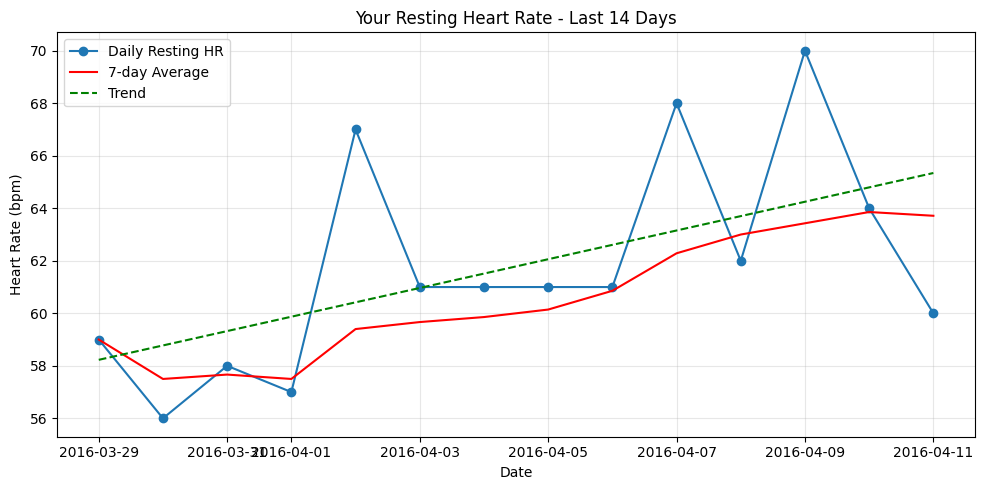

In [28]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import datetime

# ------------------------------
# 1. Load Data
# ------------------------------
# Update these paths as needed:
hr_path = "/kaggle/input/fitbit/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv"
calories_path = "/kaggle/input/fitbit/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlyCalories_merged.csv"
weight_path = "/kaggle/input/fitbit/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/weightLogInfo_merged.csv"

# Read the CSV files
df_hr = pd.read_csv(hr_path)
df_cal = pd.read_csv(calories_path)
df_weight = pd.read_csv(weight_path)

# ------------------------------
# 2. Convert Date/Time Columns
# ------------------------------
df_hr['Time'] = pd.to_datetime(df_hr['Time'], errors='coerce')
df_cal['ActivityHour'] = pd.to_datetime(df_cal['ActivityHour'], errors='coerce')
df_weight['Date'] = pd.to_datetime(df_weight['Date'], errors='coerce')

# ------------------------------
# 3. Aggregate Heart Rate Data (Hourly)
# ------------------------------
df_hr_hourly = df_hr.groupby(
    ['Id', df_hr['Time'].dt.floor('h')]
).agg({'Value': ['mean', 'min', 'max', 'std']}).reset_index()

# Flatten column names
df_hr_hourly.columns = ['Id', 'Hour', 'HR_Mean', 'HR_Min', 'HR_Max', 'HR_Std']

# ------------------------------
# 4. Calculate Daily Resting Heart Rate
# ------------------------------
df_hr['Date'] = df_hr['Time'].dt.date
# Get resting heart rate (RHR) as the 5th percentile of heart rate values for each day
df_resting = df_hr.groupby(['Id', 'Date'])['Value'].agg(
    lambda x: np.percentile(x, 5) if len(x) > 0 else np.nan
).reset_index()
df_resting.columns = ['Id', 'Date', 'RestingHR']
df_resting['Date'] = pd.to_datetime(df_resting['Date'])

# Calculate 7-day moving average for smoother trend analysis
df_resting = df_resting.sort_values(['Id', 'Date'])
df_resting['RHR_7day_MA'] = df_resting.groupby('Id')['RestingHR'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# ------------------------------
# 5. Analyze RHR Trends
# ------------------------------
# Function to analyze trend over the last n days
def analyze_trend(rhr_series, days=7):
    if len(rhr_series) < days:
        return "Insufficient data"
    
    recent_data = rhr_series.iloc[-days:]
    
    # Simple linear regression to get slope
    x = np.arange(len(recent_data))
    y = recent_data.values
    slope, _ = np.polyfit(x, y, 1)
    
    # Calculate percent change
    first_val = recent_data.iloc[0]
    last_val = recent_data.iloc[-1]
    percent_change = ((last_val - first_val) / first_val) * 100 if first_val > 0 else 0
    
    # Variability (standard deviation)
    variability = recent_data.std()
    
    # Determine trend direction and magnitude
    if abs(percent_change) < 3:
        direction = "consistent"
        magnitude = "stable"
    else:
        direction = "upward" if slope > 0 else "downward"
        if abs(percent_change) < 5:
            magnitude = "slight"
        elif abs(percent_change) < 10:
            magnitude = "moderate"
        else:
            magnitude = "significant"
    
    return {
        "direction": direction,
        "magnitude": magnitude,
        "percent_change": percent_change,
        "variability": variability,
        "slope": slope
    }

# ------------------------------
# 6. Smart Mirror Health Insights
# ------------------------------
def get_smart_mirror_insights(trend_data, last_rhr, bmi=None, hr_recovery=None, activity_level=None):
    direction = trend_data["direction"]
    magnitude = trend_data["magnitude"]
    variability = trend_data["variability"]
    
    # Base state assessment from RHR - Using simple, clear language
    if direction == "consistent":
        if last_rhr < 60:
            base_state = "Your heart is working efficiently even at rest - a sign of good fitness"
        elif last_rhr < 70:
            base_state = "Your resting heart rate is in a healthy range"
        elif last_rhr < 80:
            base_state = "Your heart rate is in a normal range, but there's room for improvement"
        else:
            base_state = "Your heart is working harder than ideal at rest"
    
    elif direction == "upward":
        if magnitude == "slight":
            base_state = "Your heart has been working a bit harder lately - this might indicate some fatigue"
        elif magnitude == "moderate":
            base_state = "Your heart rate has been increasing - this could be due to stress or the beginning of an illness"
        else:
            base_state = "Your heart rate has increased significantly - this could indicate stress, illness, or overtraining"
    
    elif direction == "downward":
        if magnitude == "slight":
            base_state = "Your heart has been working a bit less hard lately - a good sign of recovery"
        elif magnitude == "moderate":
            base_state = "Your heart rate has been decreasing - this shows your fitness is improving"
        else:
            base_state = "Your heart rate has decreased significantly - your fitness appears to be improving well"
    
    else:
        base_state = "It's hard to determine a clear pattern in your heart rate"
    
    # Daily consistency insights in simple terms
    if variability > 5:
        additional_insight = "Your daily heart rate varies quite a bit day to day"
    elif variability > 3:
        additional_insight = "Your heart rate shows some variation from day to day"
    else:
        additional_insight = "Your heart rate is very consistent day to day"
    
    # BMI insights in conversational language
    bmi_insight = ""
    if bmi is not None:
        if bmi < 18.5:
            bmi_insight = "Your BMI is below the recommended range, which might affect your heart health."
        elif bmi < 25:
            bmi_insight = "Your BMI is in a healthy range, which is good for your heart."
        elif bmi < 30:
            bmi_insight = "Your BMI is slightly elevated, which can put some extra work on your heart."
        else:
            bmi_insight = "Your BMI is higher than recommended, which might be making your heart work harder."
    
    # Heart rate recovery insights
    recovery_insight = ""
    if hr_recovery is not None:
        if hr_recovery < 15:
            recovery_insight = "Your heart doesn't slow down as quickly as it could after exertion."
        elif hr_recovery < 25:
            recovery_insight = "Your heart recovers at a normal rate after activity."
        else:
            recovery_insight = "Your heart recovers very quickly after activity - a sign of good fitness."
    
    # Activity level insights
    activity_insight = ""
    if activity_level is not None:
        if activity_level == "sedentary":
            activity_insight = "You could benefit from being more active throughout the day."
        elif activity_level == "moderate":
            activity_insight = "You have a good amount of activity in your day."
        else:  # active
            activity_insight = "You're maintaining an active lifestyle, which is great for your heart."
    
    # Combine insights for the smart mirror display
    health_summary = f"{base_state}. {additional_insight}."
    
    additional_insights = []
    if bmi_insight:
        additional_insights.append(bmi_insight)
    if recovery_insight:
        additional_insights.append(recovery_insight)
    if activity_insight:
        additional_insights.append(activity_insight)
    
    return {
        "health_summary": health_summary,
        "additional_insights": additional_insights
    }

# ------------------------------
# 7. Smart Mirror Recommendations
# ------------------------------
def get_smart_mirror_recommendations(trend_data, last_rhr, activity_level=None):
    direction = trend_data["direction"]
    magnitude = trend_data["magnitude"]
    variability = trend_data["variability"]
    
    recommendations = []
    
    # Simplified, actionable recommendations based on trends
    if direction == "upward" and magnitude in ['moderate', 'significant']:
        recommendations.append("Try to get 7-8 hours of sleep tonight")
        recommendations.append("Take a few minutes to relax and breathe deeply")
        recommendations.append("Consider a lighter workout today")
        recommendations.append("Stay hydrated - aim for 8 glasses of water")
        recommendations.append("Track what might be causing stress in your life")
    
    elif direction == "downward" and magnitude in ['moderate', 'significant']:
        recommendations.append("Your fitness routine seems to be working well")
        recommendations.append("Keep up your current sleep and exercise habits")
        recommendations.append("Consider adding a new challenge to your workouts")
        recommendations.append("Track how you feel during exercise - you might be getting stronger")
    
    else:  # consistent or slight changes
        if last_rhr < 70:
            recommendations.append("Your heart health looks good - maintain your routines")
            recommendations.append("Mix in some interval training for additional benefits")
            recommendations.append("Keep monitoring your trends for any changes")
        else:
            recommendations.append("Try adding a 30-minute walk to your daily routine")
            recommendations.append("Aim to go to bed at the same time each night")
            recommendations.append("Include active recovery like gentle stretching or yoga")
            recommendations.append("Notice how different foods affect how you feel")
    
    # Additional recommendations based on activity level
    if activity_level == "sedentary":
        recommendations.append("Try to stand up and move around for 5 minutes every hour")
        recommendations.append("Consider taking the stairs instead of the elevator today")
    
    # Limit to top 3 most important recommendations
    if len(recommendations) > 3:
        recommendations = recommendations[:3]
    
    return recommendations

# ------------------------------
# 8. Merge DataFrames for Base Model
# ------------------------------
df_merge = pd.merge(df_hr_hourly, df_cal, left_on=['Id', 'Hour'], right_on=['Id', 'ActivityHour'], how='inner')

df_merge['Date'] = df_merge['Hour'].dt.date
df_weight['Date'] = df_weight['Date'].dt.date

df_merge = pd.merge(df_merge, df_weight[['Id', 'Date', 'WeightKg', 'BMI']], on=['Id', 'Date'], how='left')

# Merge with resting HR data
df_merge['Date'] = pd.to_datetime(df_merge['Date'])
df_merge = pd.merge(df_merge, df_resting[['Id', 'Date', 'RestingHR', 'RHR_7day_MA']], on=['Id', 'Date'], how='left')

# ------------------------------
# 9. Feature Engineering
# ------------------------------
df_merge['HR_Recovery'] = df_merge['HR_Max'] - df_merge['HR_Min']
df_merge['Sedentary'] = (df_merge['Calories'].fillna(0) < 50).astype(int)

# Create a health status label
df_merge['Health_Status'] = np.where(
    (df_merge['RestingHR'] < 90) & (df_merge['HR_Recovery'] > 12) & (df_merge['BMI'].fillna(25) < 25),
    1,  # Healthy
    0   # Unhealthy
)

# ------------------------------
# 10. Prepare Data for Modeling
# ------------------------------
features = ['HR_Mean', 'HR_Min', 'HR_Max', 'HR_Std', 'Calories', 'WeightKg', 'BMI', 
            'RestingHR', 'RHR_7day_MA', 'HR_Recovery', 'Sedentary']
X = df_merge[features]
y = df_merge['Health_Status']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=features)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ------------------------------
# 11. Split the Data and Train the Classifier
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# ------------------------------
# 12. Evaluate the Model
# ------------------------------
y_pred = clf.predict(X_test)
print("Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ------------------------------
# 13. Feature Importance Analysis
# ------------------------------
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(clf.coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# ------------------------------
# 14. SMART MIRROR USER ANALYSIS (Modified for better UX)
# ------------------------------
def generate_smart_mirror_report(user_id=None):
    """Generate a user-friendly health report for the smart mirror interface"""
    
    # Find users with sufficient data (at least 14 days of heart rate data)
    user_counts = df_resting.groupby('Id').size()
    eligible_users = user_counts[user_counts >= 14].index.tolist()
    
    if not eligible_users:
        return {
            "status": "error",
            "message": "Not enough data to generate health insights. Please sync your Fitbit for at least 14 days."
        }
    
    # If no specific user_id is provided, select a random user
    if user_id is None or user_id not in eligible_users:
        user_id = random.choice(eligible_users)
    
    # Get user's RHR data
    user_rhr_data = df_resting[df_resting['Id'] == user_id].sort_values('Date')
    
    # Get the user's other health metrics (using the most recent data available)
    user_recent_data = df_merge[df_merge['Id'] == user_id].sort_values('Date', ascending=False)
    
    if user_recent_data.empty:
        return {
            "status": "error",
            "message": "No recent health data found. Please sync your Fitbit."
        }
    
    # Get user metrics
    recent_bmi = user_recent_data['BMI'].iloc[0] if not pd.isna(user_recent_data['BMI'].iloc[0]) else None
    recent_hr_recovery = user_recent_data['HR_Recovery'].iloc[0]
    last_rhr = user_rhr_data['RestingHR'].iloc[-1]
    
    # Determine activity level from calories data
    avg_daily_calories = df_cal[df_cal['Id'] == user_id].groupby(
        pd.to_datetime(df_cal['ActivityHour']).dt.date
    )['Calories'].sum().mean()
    
    if avg_daily_calories < 1800:
        activity_level = "sedentary"
    elif avg_daily_calories < 2200:
        activity_level = "moderate"
    else:
        activity_level = "active"
    
    # Analyze Trends
    short_term_trend = analyze_trend(user_rhr_data['RestingHR'], days=7)
    if not isinstance(short_term_trend, dict):
        return {
            "status": "error",
            "message": "Not enough recent data to analyze trends. Please sync your Fitbit."
        }
    
    # Generate smart mirror insights
    mirror_insights = get_smart_mirror_insights(
        short_term_trend,
        last_rhr,
        recent_bmi,
        recent_hr_recovery,
        activity_level
    )
    
    # Generate recommendations
    recommendations = get_smart_mirror_recommendations(
        short_term_trend,
        last_rhr,
        activity_level
    )
    
    # Make health prediction using our model
    # Get average metrics for this user
    user_avg_metrics = df_merge[df_merge['Id'] == user_id][features].mean().to_dict()
    
    # Create a DataFrame for prediction
    user_prediction_data = pd.DataFrame([user_avg_metrics])
    
    # Process the data
    user_data_processed = scaler.transform(imputer.transform(user_prediction_data))
    
    # Get predictions
    health_prediction = clf.predict(user_data_processed)[0]
    health_prob = clf.predict_proba(user_data_processed)[0][1]
    
    # Create visualization
    plt.figure(figsize=(10, 5))
    plt.plot(user_rhr_data['Date'][-14:], user_rhr_data['RestingHR'][-14:], 'o-', label='Daily Resting HR')
    plt.plot(user_rhr_data['Date'][-14:], user_rhr_data['RHR_7day_MA'][-14:], 'r-', label='7-day Average')
    
    # Add trend line
    x = np.arange(len(user_rhr_data[-14:]))
    y = user_rhr_data['RestingHR'][-14:].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(user_rhr_data['Date'][-14:], p(x), "g--", label="Trend")
    
    plt.title(f"Your Resting Heart Rate - Last 14 Days")
    plt.xlabel('Date')
    plt.ylabel('Heart Rate (bpm)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Save the plot for the smart mirror display
    chart_filename = f'user_{user_id}_rhr_trend.png'
    plt.savefig(chart_filename)
    
    # Calculate readiness score (simplified for smart mirror)
    # Scale from 0-100 based on our health indicators
    readiness_base = health_prob * 100  # Base from our model
    
    # Adjust for recent trend
    if short_term_trend['direction'] == 'upward' and short_term_trend['magnitude'] != 'slight':
        readiness_adjustment = -10 if short_term_trend['magnitude'] == 'significant' else -5
    elif short_term_trend['direction'] == 'downward' and short_term_trend['magnitude'] != 'slight':
        readiness_adjustment = 5 if short_term_trend['magnitude'] == 'significant' else 3
    else:
        readiness_adjustment = 0
        
    # Adjust for variability
    variability_adjustment = -5 if short_term_trend['variability'] > 5 else 0
    
    # Calculate final score
    readiness_score = max(0, min(100, readiness_base + readiness_adjustment + variability_adjustment))
    
    # Format date for display
    today = datetime.datetime.now().strftime('%A, %B %d')
    
    # Generate complete report for smart mirror display
    report = {
        "status": "success",
        "user_id": user_id,
        "date": today,
        "resting_heart_rate": int(round(last_rhr)),
        "health_summary": mirror_insights["health_summary"],
        "additional_insights": mirror_insights["additional_insights"],
        "recommendations": recommendations,
        "readiness_score": int(round(readiness_score)),
        "health_status": "HEALTHY" if health_prediction == 1 else "NEEDS ATTENTION",
        "health_confidence": f"{health_prob:.0%}",
        "chart_filename": chart_filename,
        "trend_direction": short_term_trend['direction'],
        "trend_magnitude": short_term_trend['magnitude'],
        "activity_level": activity_level,
        "bmi": None if recent_bmi is None else round(recent_bmi, 1)
    }
    
    return report

# Execute for a random user
smart_mirror_report = generate_smart_mirror_report()

# Print the report in a formatted way for smart mirror display
if smart_mirror_report["status"] == "success":
    print("\n" + "=" * 50)
    print(f"SMART MIRROR HEALTH REPORT - {smart_mirror_report['date']}")
    print("=" * 50)
    
    print(f"\nGood morning! Your resting heart rate is {smart_mirror_report['resting_heart_rate']} bpm.")
    print(f"\n{smart_mirror_report['health_summary']}")
    
    for insight in smart_mirror_report['additional_insights']:
        print(f"• {insight}")
    
    print(f"\nYour wellness score today is {smart_mirror_report['readiness_score']}/100")
    print(f"Overall status: {smart_mirror_report['health_status']}")
    
    print("\nRECOMMENDATIONS FOR TODAY:")
    for i, rec in enumerate(smart_mirror_report['recommendations'], 1):
        print(f"{i}. {rec}")
    
    print(f"\nChart created at: {smart_mirror_report['chart_filename']}")
else:
    print(f"\nError: {smart_mirror_report['message']}")